https://goldinlocks.github.io/Introduction-to-A-B-testing-in-python/

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from functools import reduce
from sklearn import preprocessing
from scipy import stats

In [2]:
# 把使用者分成 Control ＆ Test , user id為key
user_table = pd.read_csv('user_table.csv')
length = len(user_table['user_id'])
k = np.random.binomial(1, 0.5, length)
user_table['group'] = k 
user_table['group'] = user_table['group'].replace(0, 'Control', regex=True)
user_table['group'] = user_table['group'].replace(1, 'Test', regex=True)
user_table.head()

,user_id,date,device,sex,group
0,450007,2015-02-28,Desktop,Female,Test
1,756838,2015-01-13,Desktop,Male,Control
2,568983,2015-04-09,Desktop,Male,Control
3,190794,2015-02-18,Desktop,Female,Control
4,537909,2015-01-15,Desktop,Male,Test


In [59]:
pd.Series(k).value_counts()

0    45605
1    44795
dtype: int64

In [6]:
# Read in all csv files , 客戶網頁瀏覽資料
home_page_table = pd.read_csv('home_page_table.csv')
search_page_table = pd.read_csv('search_page_table.csv')
payment_page_table = pd.read_csv('payment_page_table.csv')
payment_confirmation_table = pd.read_csv('payment_confirmation_table.csv')

# Compile the list of dataframes you want to merge
data_frames = [user_table, home_page_table, search_page_table, payment_page_table, payment_confirmation_table]

# Merge all dataframes in the list together on user_id
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'], how='outer'), data_frames)
df_merged.columns = ['user_id', 'date', 'device', 'sex', 'group', 'home_page', 'search_page', 
                     'payment_page', 'payment_confirm']
df_merged.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 0 to 90399
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          90400 non-null  int64 
 1   date             90400 non-null  object
 2   device           90400 non-null  object
 3   sex              90400 non-null  object
 4   group            90400 non-null  object
 5   home_page        90400 non-null  object
 6   search_page      45200 non-null  object
 7   payment_page     6030 non-null   object
 8   payment_confirm  452 non-null    object
dtypes: int64(1), object(8)
memory usage: 6.9+ MB


In [50]:
df_merged.head()#['payment_confirm'].value_counts()

,user_id,date,device,sex,group,home_page,search_page,payment_page,payment_confirm
0,450007,2015-02-28,Desktop,Female,Test,1,0,0,0
1,756838,2015-01-13,Desktop,Male,Control,1,0,0,0
2,568983,2015-04-09,Desktop,Male,Control,1,1,0,0
3,190794,2015-02-18,Desktop,Female,Control,1,1,0,0
4,537909,2015-01-15,Desktop,Male,Test,1,0,0,0


Data Preprocessing

We create 4
new columns indicating whether a user is in home_page, search_page, payment_page, confirmation_page, 1 indicating that one person is in this page and 0 other wise.

In [8]:
df_merged['date'] = pd.to_datetime(df_merged['date'])

trans_features = df_merged[['home_page', 'search_page', 'payment_page', 'payment_confirm']]
trans_features = trans_features.replace(np.nan, 'none', regex=True)
other_features = df_merged[['user_id', 'date', 'device', 'sex', 'group']]

le = preprocessing.LabelEncoder()
trans_features = trans_features.apply(lambda x: le.fit_transform(x))

df_merged = pd.concat([other_features, trans_features], axis=1)
df_merged['home_page'] = df_merged['home_page'].replace(0, 1)

In [9]:
df_merged['payment_confirm'].value_counts()

0    89948
1      452
Name: payment_confirm, dtype: int64

In [63]:
test_n = len(df_merged.loc[df_merged.group == 'Test'])
cont_n = len(df_merged.loc[df_merged.group == 'Control'])
df_merged.loc[df_merged.group == 'Test', 'payment_confirm'] = np.random.poisson(0.089, test_n)
df_merged.loc[df_merged.group == 'Control', 'payment_confirm'] = np.random.poisson(0.089, cont_n)#0.079

In [61]:
df_merged['payment_confirm'].value_counts()

0    83116
1     7006
2      271
3        7
Name: payment_confirm, dtype: int64

# Grouping and aggregating our combined dataset¶
EDA,以特定的類別欄位區分後檢視其個別的payment_confirm行為，或網頁瀏覽行為

In [29]:
daily_purchase_data = df_merged.groupby(by=['date'], as_index=False)
daily_purchase_data = daily_purchase_data.agg({'payment_confirm': ['sum', 'count']})
daily_purchase_data.columns = daily_purchase_data.columns.droplevel(level=0)
daily_purchase_data.columns = ['date', 'sum', 'count']

In [30]:
daily_purchase_data.head()

,date,sum,count
0,2015-01-01,52,712
1,2015-01-02,65,721
2,2015-01-03,81,760
3,2015-01-04,55,713
4,2015-01-05,59,754


In [31]:
Male = df_merged[df_merged.sex == 'Male']
Female = df_merged[df_merged.sex == 'Female']

Desktop = df_merged[df_merged.device == 'Desktop']
Mobile = df_merged[df_merged.device == 'Mobile']

Male_Desktop = Male[Male.device == 'Desktop']
Male_Mobile = Male[Male.device == 'Mobile']

Female_Desktop = Female[Female.device == 'Desktop']
Female_Mobile = Female[Female.device == 'Mobile']

In [32]:
Male_daily_purchase_data = Male.groupby(by=['date'], as_index=False)
Male_daily_purchase_data = Male_daily_purchase_data.agg({'payment_confirm': ['sum', 'count']})
Male_daily_purchase_data.columns = Male_daily_purchase_data.columns.droplevel(level=0)
Male_daily_purchase_data.columns = ['date', 'sum', 'count']

Female_daily_purchase_data = Female.groupby(by=['date'], as_index=False)
Female_daily_purchase_data = Female_daily_purchase_data.agg({'payment_confirm': ['sum', 'count']})
Female_daily_purchase_data.columns = Female_daily_purchase_data.columns.droplevel(level=0)
Female_daily_purchase_data.columns = ['date', 'sum', 'count']

Desktop_daily_purchase_data = Desktop.groupby(by=['date'], as_index=False)
Desktop_daily_purchase_data = Desktop_daily_purchase_data.agg({'payment_confirm': ['sum', 'count']})
Desktop_daily_purchase_data.columns = Desktop_daily_purchase_data.columns.droplevel(level=0)
Desktop_daily_purchase_data.columns = ['date', 'sum', 'count']

Mobile_daily_purchase_data = Mobile.groupby(by=['date'], as_index=False)
Mobile_daily_purchase_data = Mobile_daily_purchase_data.agg({'payment_confirm': ['sum', 'count']})
Mobile_daily_purchase_data.columns = Mobile_daily_purchase_data.columns.droplevel(level=0)
Mobile_daily_purchase_data.columns = ['date', 'sum', 'count']

In [33]:
daily_visitor_data = df_merged.groupby(by=['date'], as_index=False)
daily_visitor_data = daily_visitor_data.agg({'home_page': ['sum', 'count']})
daily_visitor_data.columns = daily_visitor_data.columns.droplevel(level=0)
daily_visitor_data.columns = ['date', 'sum', 'count']

daily_visitor_Male = Male.groupby(by=['date'], as_index=False)
daily_visitor_Male = daily_visitor_Male.agg({'home_page': ['sum', 'count']})
daily_visitor_Male.columns = daily_visitor_Male.columns.droplevel(level=0)
daily_visitor_Male.columns = ['date', 'sum', 'count']

daily_visitor_Female = Female.groupby(by=['date'], as_index=False)
daily_visitor_Female = daily_visitor_Female.agg({'home_page': ['sum', 'count']})
daily_visitor_Female.columns = daily_visitor_Female.columns.droplevel(level=0)
daily_visitor_Female.columns = ['date', 'sum', 'count']

daily_visitor_Desktop = Desktop.groupby(by=['date'], as_index=False)
daily_visitor_Desktop = daily_visitor_Desktop.agg({'home_page': ['sum', 'count']})
daily_visitor_Desktop.columns = daily_visitor_Desktop.columns.droplevel(level=0)
daily_visitor_Desktop.columns = ['date', 'sum', 'count']

daily_visitor_Mobile = Mobile.groupby(by=['date'], as_index=False)
daily_visitor_Mobile = daily_visitor_Mobile.agg({'home_page': ['sum', 'count']})
daily_visitor_Mobile.columns = daily_visitor_Mobile.columns.droplevel(level=0)
daily_visitor_Mobile.columns = ['date', 'sum', 'count']

daily_visitor_Mobile_Female = Female_Mobile.groupby(by=['date'], as_index=False)
daily_visitor_Mobile_Female = daily_visitor_Mobile_Female.agg({'home_page': ['sum', 'count']})
daily_visitor_Mobile_Female.columns = daily_visitor_Mobile_Female.columns.droplevel(level=0)
daily_visitor_Mobile_Female.columns = ['date', 'sum', 'count']

daily_visitor_Desktop_Female = Female_Desktop.groupby(by=['date'], as_index=False)
daily_visitor_Desktop_Female = daily_visitor_Desktop_Female.agg({'home_page': ['sum', 'count']})
daily_visitor_Desktop_Female.columns = daily_visitor_Desktop_Female.columns.droplevel(level=0)
daily_visitor_Desktop_Female.columns = ['date', 'sum', 'count']

daily_visitor_Mobile_Male = Male_Mobile.groupby(by=['date'], as_index=False)
daily_visitor_Mobile_Male = daily_visitor_Mobile_Male.agg({'home_page': ['sum', 'count']})
daily_visitor_Mobile_Male.columns = daily_visitor_Mobile_Male.columns.droplevel(level=0)
daily_visitor_Mobile_Male.columns = ['date', 'sum', 'count']

daily_visitor_Desktop_Male = Male_Desktop.groupby(by=['date'], as_index=False)
daily_visitor_Desktop_Male = daily_visitor_Desktop_Male.agg({'home_page': ['sum', 'count']})
daily_visitor_Desktop_Male.columns = daily_visitor_Desktop_Male.columns.droplevel(level=0)
daily_visitor_Desktop_Male.columns = ['date', 'sum', 'count']

# EDA¶

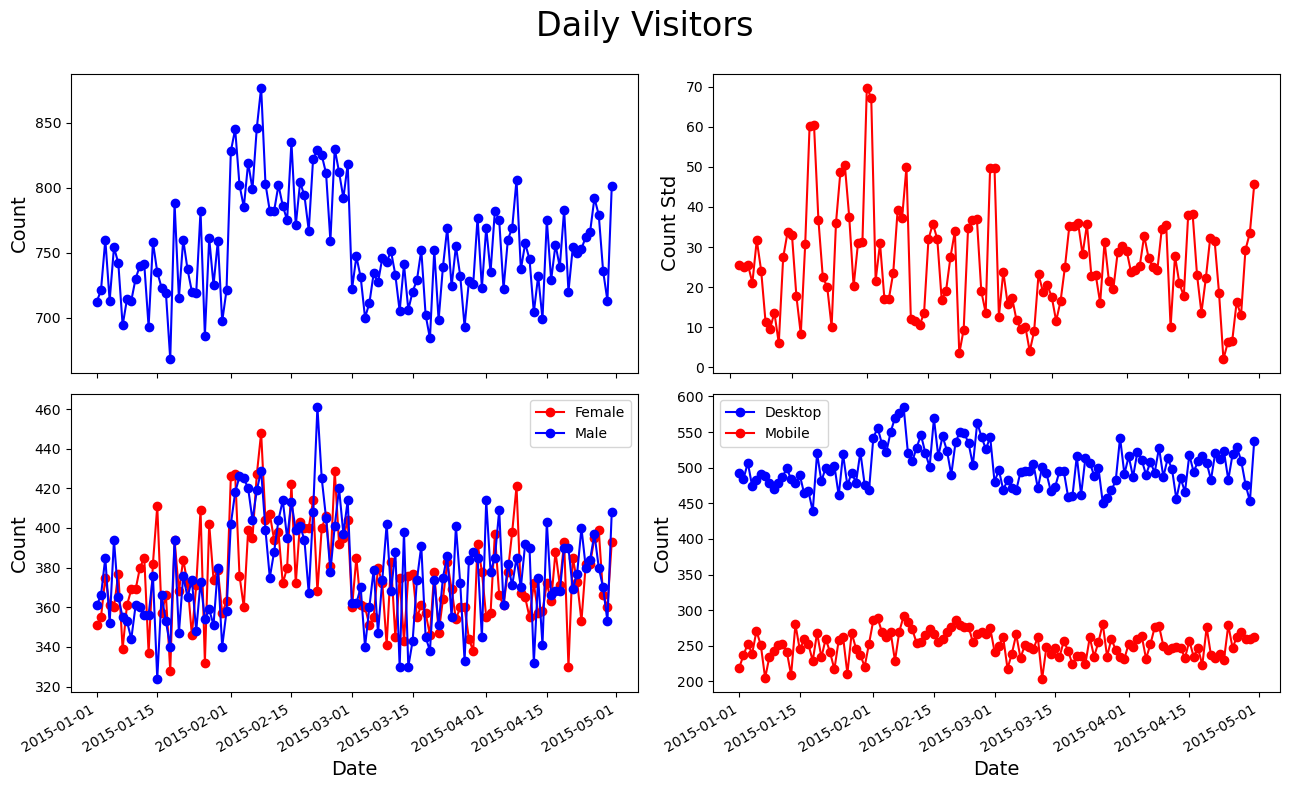

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13,8))

ax[0,0].plot(daily_visitor_data['date'], daily_visitor_data['count'], color='b', linestyle='-', marker='o')
ax[0,1].plot(daily_visitor_data['date'], daily_visitor_data['count'].rolling(3).std(), color='r', 
           linestyle='-', marker='o')

ax[1,0].plot(daily_visitor_Female['date'], daily_visitor_Female['count'], color='r', linestyle='-', marker='o', 
             label='Female')
ax[1,0].plot(daily_visitor_Male['date'], daily_visitor_Male['count'], color='b', linestyle='-', marker='o', 
             label='Male')

ax[1,1].plot(daily_visitor_Desktop['date'], daily_visitor_Desktop['count'], color='b', linestyle='-', marker='o', 
           label='Desktop')
ax[1,1].plot(daily_visitor_Mobile['date'], daily_visitor_Mobile['count'], color='r', linestyle='-', marker='o', 
           label='Mobile')

ax[1,0].set_xlabel('Date', fontsize=14)
ax[1,1].set_xlabel('Date', fontsize=14)
ax[0,1].set_ylabel('Count Std', fontsize=14)
ax[0,0].set_ylabel('Count', fontsize=14)
ax[1,1].set_ylabel('Count', fontsize=14)
ax[1,0].set_ylabel('Count', fontsize=14)
ax[1,0].legend()
ax[1,1].legend()
fig.autofmt_xdate()
plt.tight_layout()
fig.suptitle(f'Daily Visitors', fontsize=24)
plt.subplots_adjust(top=.9)
plt.show()

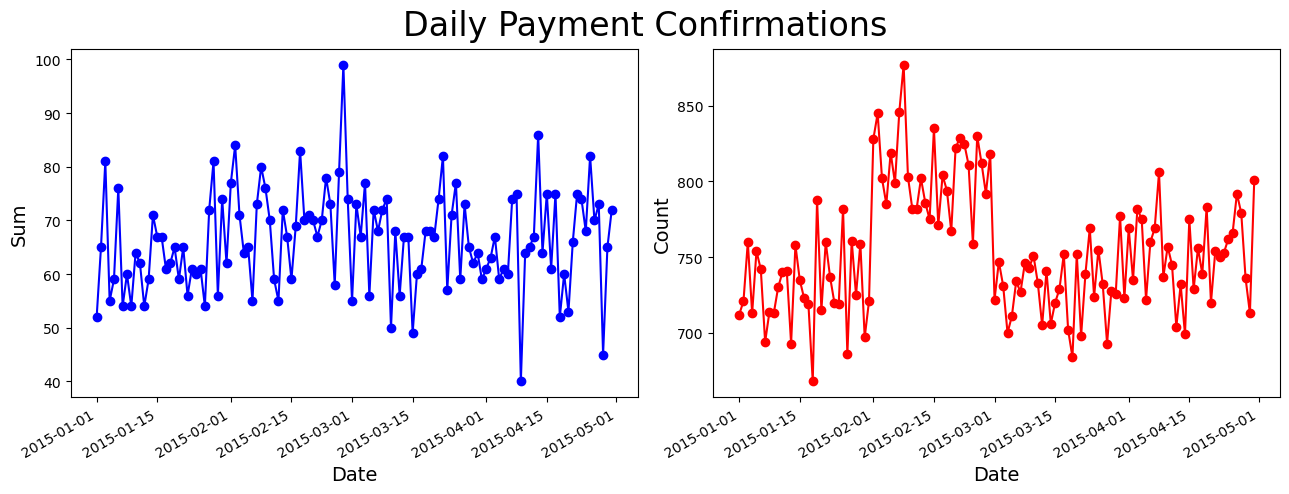

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
ax[0].plot(daily_purchase_data['date'], daily_purchase_data['sum'], color='b', linestyle='-', marker='o')
ax[1].plot(daily_purchase_data['date'], daily_purchase_data['count'], color='r', linestyle='-', marker='o')
ax[0].set_xlabel('Date', fontsize=14)
ax[1].set_xlabel('Date', fontsize=14)
ax[0].set_ylabel('Sum', fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)
fig.autofmt_xdate()
plt.tight_layout()
fig.suptitle(f'Daily Payment Confirmations', fontsize=24)
plt.subplots_adjust(top=.9)
plt.show()

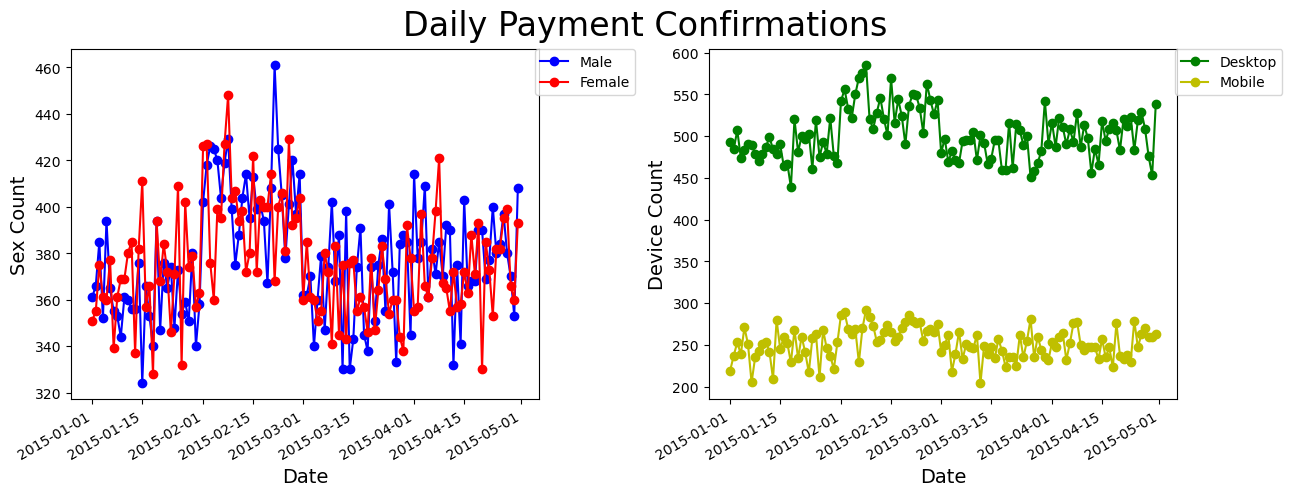

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
ax[0].plot(Male_daily_purchase_data['date'], Male_daily_purchase_data['count'], color='b', label='Male', 
           linestyle='-', marker='o')
ax[0].plot(Female_daily_purchase_data['date'], Female_daily_purchase_data['count'], color='r', label='Female', 
           linestyle='-', marker='o')
ax[1].plot(Desktop_daily_purchase_data['date'], Desktop_daily_purchase_data['count'], color='g', 
           label='Desktop', linestyle='-', marker='o')
ax[1].plot(Mobile_daily_purchase_data['date'], Mobile_daily_purchase_data['count'], color='y', label='Mobile', 
           linestyle='-', marker='o')
ax[0].set_xlabel('Date', fontsize=14)
ax[1].set_xlabel('Date', fontsize=14)
ax[0].set_ylabel('Sex Count', fontsize=14)
ax[1].set_ylabel('Device Count', fontsize=14)
ax[0].legend(bbox_to_anchor=(1.22, 1.02))
ax[1].legend(bbox_to_anchor=(1.24, 1.02))
plt.tight_layout()
fig.suptitle(f'Daily Payment Confirmations', fontsize=24)
plt.subplots_adjust(top=.9)
fig.autofmt_xdate()
plt.show()

In [37]:
# Group and aggregate our combined dataset 
grouped_purchase_data = df_merged.groupby(by = ['device', 'sex'])
purchase_summary = grouped_purchase_data.agg({'payment_confirm': ['sum', 'count']})
purchase_summary.head()
# destop device is greater than mobile device 

payment_confirm       
                           sum  count
device  sex                          
Desktop Female            2647  29997
        Male              2628  30203
Mobile  Female            1302  15078
        Male              1370  15122

# Initial A/B test design
## Response variable
* The quantity used to measure the impact of your change
* Should either be a KPI or directly related to a KPI
* The easier to measure the better
## Factors & variants
* Factors: The type of variable you are changing
 * The paywall customer greeting
* Variants: Particular changes you are testing
* Current Paywall: “I hope you enjoyed your free-trial, please consider subscribing” (control)
* Proposed Paywall: “Your free-trial has ended, don’t miss out, subscribe today!” (treatment)
## KPI: Conversion Rate
* Conversion Rate: Percentage of users who subscribe after the free trial

* Across all users or just a subset?

* Of users who convert within one week? One month?

## Why is conversion rate important?
* Strong measure of growth
* Potential early warning sign of problems
* Sensitive to changes in the overall ecosystem
* Choosing a KPI
* * Stability over time
* * Importance across different user groups
* * Correlation with other business factors
* * Conversion rate sensitivities
* * Here were working with the conversion rate metric. Specifically we will work to examine what that value becomes under different percentage
* *lifts and look at how many more conversions per day this change would result in. First we will find the average number of paywall views a * *purchases that were made per day in our observed sample.

In [38]:
# Find the mean of each field and then multiply by 1000 to scale the result
daily_purchases = daily_purchase_data['sum'].mean()
daily_paywall_views = daily_purchase_data['count'].mean()
daily_purchases = daily_purchases #* 1000
daily_paywall_views = daily_paywall_views #* 1000

print(f'Daily Purchses = {round(daily_purchases,2)}')
print(f'Daily Paywall Views = {round(daily_paywall_views,2)}')

Daily Purchses = 66.22
Daily Paywall Views = 753.33


In [39]:
# Find the conversion rate 
total_subs_count = np.sum(df_merged['payment_confirm'])
total_users_count = len(df_merged['user_id'].unique())
conversion_rate = total_subs_count / total_users_count

# Find the conversion rate std
pop_std = df_merged['payment_confirm'].std()

print(f'Total number of users = {total_users_count}')
print(f'Total number of subscribers = {total_subs_count}')
print(f'Conversion rate = {conversion_rate}, std = {pop_std}')

Total number of users = 90400
Total number of subscribers = 7947
Conversion rate = 0.08790929203539823, std = 0.295775423418605


In [40]:
small_sensitivity = 0.1 

# Find the conversion rate when increased by the percentage of the sensitivity above
small_conversion_rate = conversion_rate * (1 + 0.1) 

# Apply the new conversion rate to find how many more users per day that translates to
small_purchasers = daily_paywall_views * small_conversion_rate

# Subtract the initial daily_purcahsers number from this new value to see the lift
purchaser_lift = small_purchasers - daily_purchases

print('small_conversion_rate:',small_conversion_rate)
print('small_purchasers:',small_purchasers)
print('purchaser_lift:',purchaser_lift)

small_conversion_rate: 0.09670022123893805
small_purchasers: 72.8475
purchaser_lift: 6.622500000000002


## Data variability
* Important to understand the variability in your data
  * Does the conversion rate vary a lot among users?
  * If it does not then it will be easier to detect a change

## Calculating the sample size of our test¶

* Hypothesis that control & treatment have the same impact on the response
  * Updated paywall does not improve conversion rate
* Any observed difference is due to randomness
  * Rejecting the Null Hypothesis
  * Determine their is a difference between the treatment and control
  * Statistically significant result

# Types of error & confidence level¶
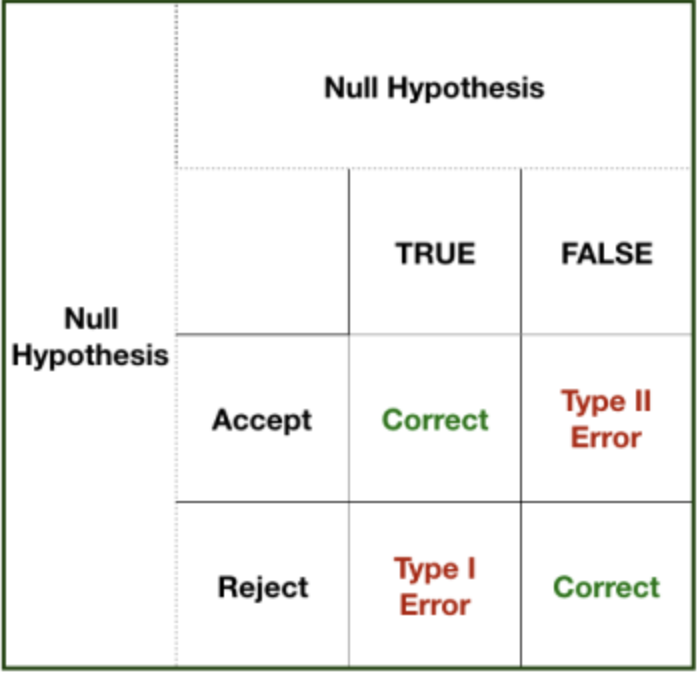

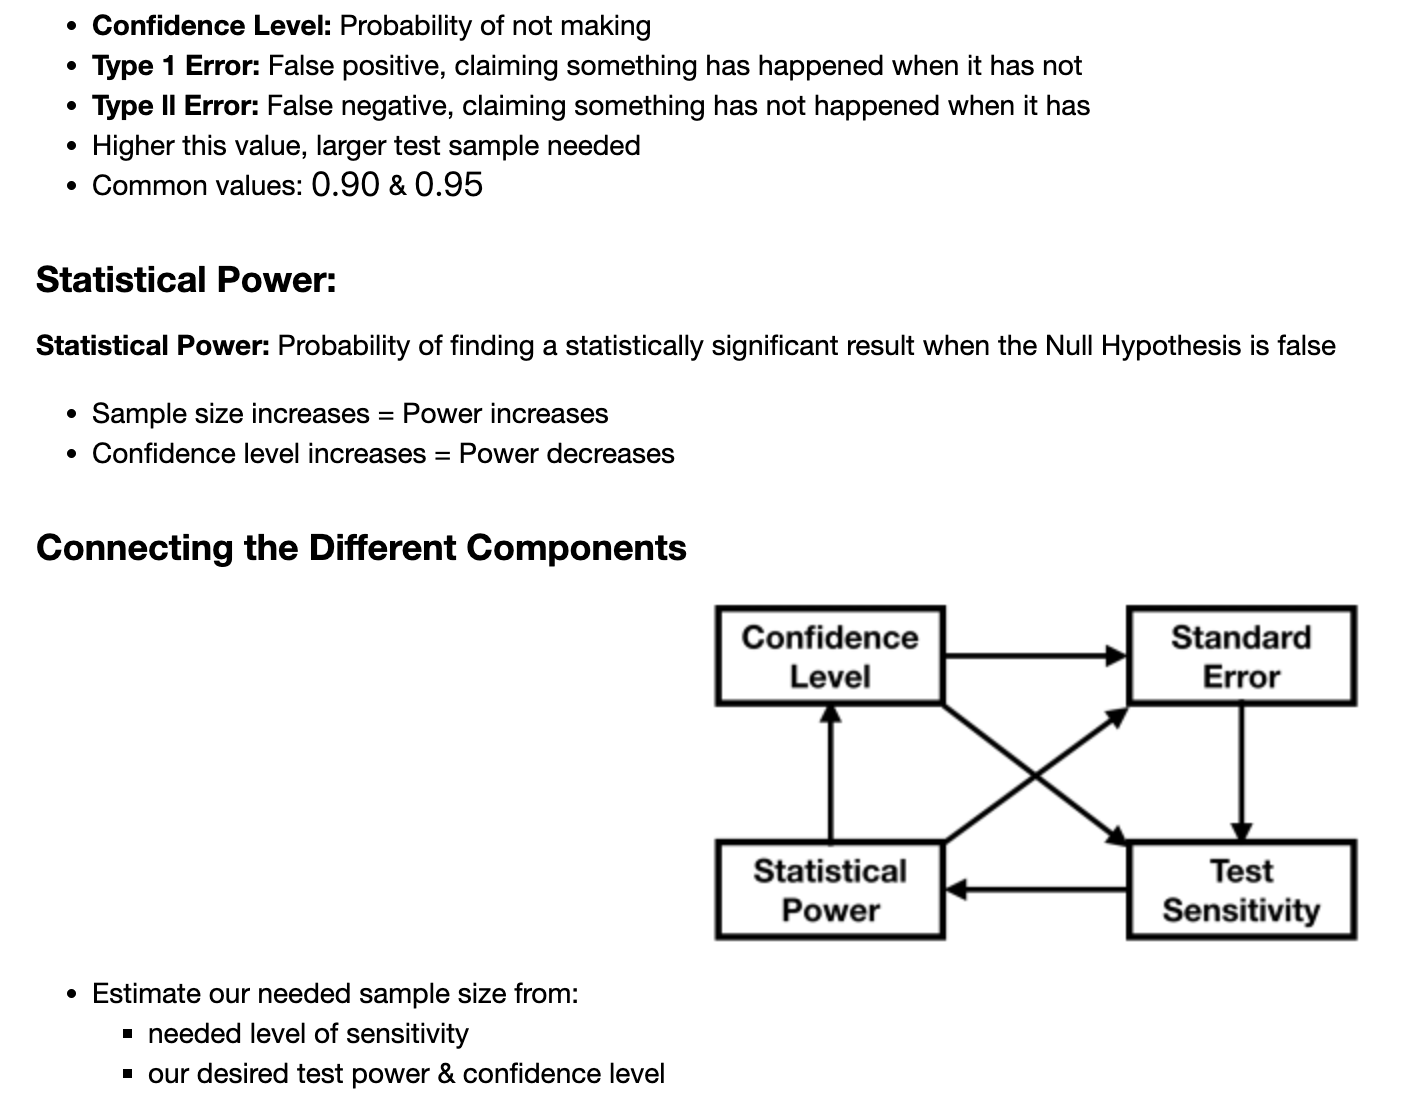

# Calculating the sample size and effect Size

To reach statistical significance, our sample size should be enough. To determine how many users we need for the test and control groups under various circumstances we will use the solve_power() function leaving nobs1 as None to get the needed sample size for our experiment.

* Effect Size: The quantified magnitude of a result present in the population. Effect size is calculated using a specific statistical measure, such as Pearson’s correlation coefficient for the relationship between variables or Cohen’s d for the difference between groups.

In [41]:
from statsmodels.stats import power as pwr

# Calculate conversion rate mean and std
purchase_mean = df_merged.payment_confirm.mean()
purchase_std = df_merged.payment_confirm.std()

# Setting the parameters and we want to increase the purchase_mean to 0.1 in this experiment
effect_size = (0.1 - purchase_mean)/purchase_std
power = 0.8
alpha = 0.05

# Calculate ratio
sizes = [cont_n,test_n]
ratio = max(sizes)/min(sizes)

# Initialize analysis and calculate sample size
analysis = pwr.TTestIndPower()
ssresult = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, nobs1=None, ratio=ratio)

print(f'Sample Size: {int(ssresult)}')

Sample Size: 9311


In [45]:
#.若今天想評估多少才是effect size也可以改用此方式
# Set parameters for entire dataset
alpha = 0.05
power = 0.8
samp_size = int(ssresult)

# Initialize analysis & calculate effect size
analysis = pwr.TTestIndPower()
esresult = analysis.solve_power(effect_size = None, 
                                power = power, 
                                nobs1 = samp_size, 
                                ratio = ratio, 
                                alpha = alpha)

print(f'Minimum detectable effect size: {round(esresult,5)}')

Minimum detectable effect size: 0.04088


In [46]:
# Set parameters
effect_size = esresult
alpha = 0.05

# Initialize analysis & calculate power
analysis = pwr.TTestIndPower()
pwresult = analysis.solve_power(effect_size=effect_size, power=None, alpha=alpha, nobs1=samp_size, ratio=ratio)

print(f'Power: {round(pwresult,3)}')

Power: 0.8


In [47]:
# 計算 control & test間的筆數
# Find the unique users in each group 
results = df_merged.groupby('group').agg({'user_id': pd.Series.nunique}) # 算 control & test間的筆數

# Find the overall number of unique users using "len" and "unique"
unique_users = len(df_merged.user_id.unique()) 

# Find the percentage in each group
results = results / unique_users * 100
print('Percentage of users in each group:','\n', results)#

Percentage of users in each group: 
            user_id
group             
Control  50.448009
Test     49.551991


In [48]:
# 檢視分層比例
# Find the unique users in each group, by device and gender
results = df_merged.groupby(by=['group', 'device', 'sex']).agg({'user_id': pd.Series.nunique}) 

# Find the overall number of unique users using "len" and "unique"
unique_users = len(df_merged.user_id.unique())

# Find the percentage in each group
results = results / unique_users * 100
print('Percentage of users in each group:','\n', results)


Percentage of users in each group: 
                           user_id
group   device  sex              
Control Desktop Female  16.714602
                Male    16.928097
        Mobile  Female   8.366150
                Male     8.439159
Test    Desktop Female  16.467920
                Male    16.482301
        Mobile  Female   8.313053
                Male     8.288717


In [62]:
test_results = df_merged[df_merged.group == 'Test']['payment_confirm']
control_results = df_merged[df_merged.group == 'Control']['payment_confirm']

test_result = stats.ttest_ind(test_results, control_results)

statistic = test_result[0]
p_value = test_result[1]

print('statistic = ', statistic)
print('p_value = ', p_value)

# Check for statistical significance
if p_value >= 0.05:
    print("Not Significant")
else:
    print("Significant Result")

statistic =  4.8537510143965354
p_value =  1.2134945121622046e-06
Significant Result


In [64]:
test_results = df_merged[df_merged.group == 'Test']['payment_confirm']
control_results = df_merged[df_merged.group == 'Control']['payment_confirm']

test_result = stats.ttest_ind(test_results, control_results)

statistic = test_result[0]
p_value = test_result[1]

print('statistic = ', statistic)
print('p_value = ', p_value)

# Check for statistical significance
if p_value >= 0.05:
    print("Not Significant")
else:
    print("Significant Result")

statistic =  0.38318216904909086
p_value =  0.7015855990017654
Not Significant
